In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import joblib
sns.set()

from dotenv import load_dotenv
from binance.client import Client
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix  # for evaluating model performance

/Users/goldenhello/Desktop/Quant/Matic_Strategy/myenv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
Analyze= 'Stocks' #Stocks or Cryptos

In [3]:

if Analyze == 'Stocks':
    df = pd.read_json('/Users/goldenhello/Desktop/Quant/Matic_Strategy/data_stocks_1.json')
elif Analyze == 'Cryptos':
    df = pd.read_json('/Users/goldenhello/Desktop/Quant/Matic_Strategy/data_1.json')
else:
    print('Select data to analyze')
    df = None  # or handle appropriately, e.g., raise an exception or set to an empty DataFrame


In [4]:
df.columns

Index(['Open time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Gain/Loss',
       'Percentage Change', 'Conditional Cumulative Sum', '300 Period MA',
       '60 Period MA', '14 Period MA', 'Distance_300_MA', 'Close_prev_1',
       'Close_prev_2', 'Close_prev_3', 'Close_prev_4', 'Close_prev_5',
       'Close_prev_6', 'Close_prev_7', 'Close_prev_8', 'Close_prev_9',
       'Close_prev_10', 'Close_future_1', 'Close_future_2', 'Close_future_3',
       'Close_future_4', 'Close_future_5', 'Close_future_6', 'Close_future_7',
       'Close_future_8', 'Close_future_9', 'Close_future_10', 'RSI_300',
       'Processed Difference'],
      dtype='object')

In [5]:
df = df.drop(['Close_prev_1','Close_prev_2','Close_prev_3','Close_prev_4','Close_prev_5',
              'Close_prev_6','Close_prev_7','Close_prev_8','Close_prev_9','Close_prev_10',
              'Close_future_1', 'Close_future_2', 'Close_future_3', 'Close_future_4', 
              'Close_future_5', 'Close_future_6', 'Close_future_7',
              'Close_future_8', 'Close_future_9', 'Close_future_10'], axis=1)
df['G/L_RSI_300']=df['300 Period MA']/df['Gain/Loss']

In [6]:
# Replace inf/-inf with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Check for NaNs and handle them
if df.isna().any().any():
    # Option 1: Fill NaNs with a specified value (e.g., mean of the column)
    df.fillna(df.mean(), inplace=True)
    
    # Option 2: Drop rows with NaNs
    # df.dropna(inplace=True)

# Convert dtype to float64 if float32 is insufficient
df = df.astype(np.float64)

In [7]:
df.columns

Index(['Open time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Gain/Loss',
       'Percentage Change', 'Conditional Cumulative Sum', '300 Period MA',
       '60 Period MA', '14 Period MA', 'Distance_300_MA', 'RSI_300',
       'Processed Difference', 'G/L_RSI_300'],
      dtype='object')

In [8]:
# Assuming 'Processed Difference' is the dependent variable
X = df.drop('Processed Difference', axis=1)  # Independent variables
y = df['Processed Difference']  # Dependent variable

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # 40% data as test set

In [9]:
X_train = X_train.drop('Open time', axis=1)
X_test = X_test.drop('Open time', axis=1)

In [10]:
rf_classifier = RandomForestClassifier(bootstrap=False, class_weight='balanced', criterion='gini',
                       max_depth=None, max_features=10, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=700, n_jobs=-1, oob_score=False,
                       random_state=35, verbose=0, warm_start=False)

In [11]:
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)

In [12]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.51


In [13]:
# Create a DataFrame with actual and predicted values
results_df = pd.DataFrame({
    'Actual Values': y_test,
    'Predicted Values': y_pred
})

# Optionally, reset index to make it cleaner
results_df.reset_index(drop=True, inplace=True)

In [14]:
results_df.tail(20)

,Actual Values,Predicted Values
292,3.0,3.0
293,0.0,0.0
294,2.0,0.0
295,2.0,1.0
296,4.0,6.0
297,2.0,2.0
298,1.0,0.0
299,1.0,1.0
300,5.0,4.0
301,1.0,2.0


                       Feature  Importance
8                300 Period MA    0.139652
9                 60 Period MA    0.112661
4                       Volume    0.098060
10                14 Period MA    0.087672
3                        Close    0.085356
7   Conditional Cumulative Sum    0.073806
2                          Low    0.056828
13                 G/L_RSI_300    0.056233
11             Distance_300_MA    0.055800
1                         High    0.054533
12                     RSI_300    0.049632
5                    Gain/Loss    0.043740
6            Percentage Change    0.043223
0                         Open    0.042805


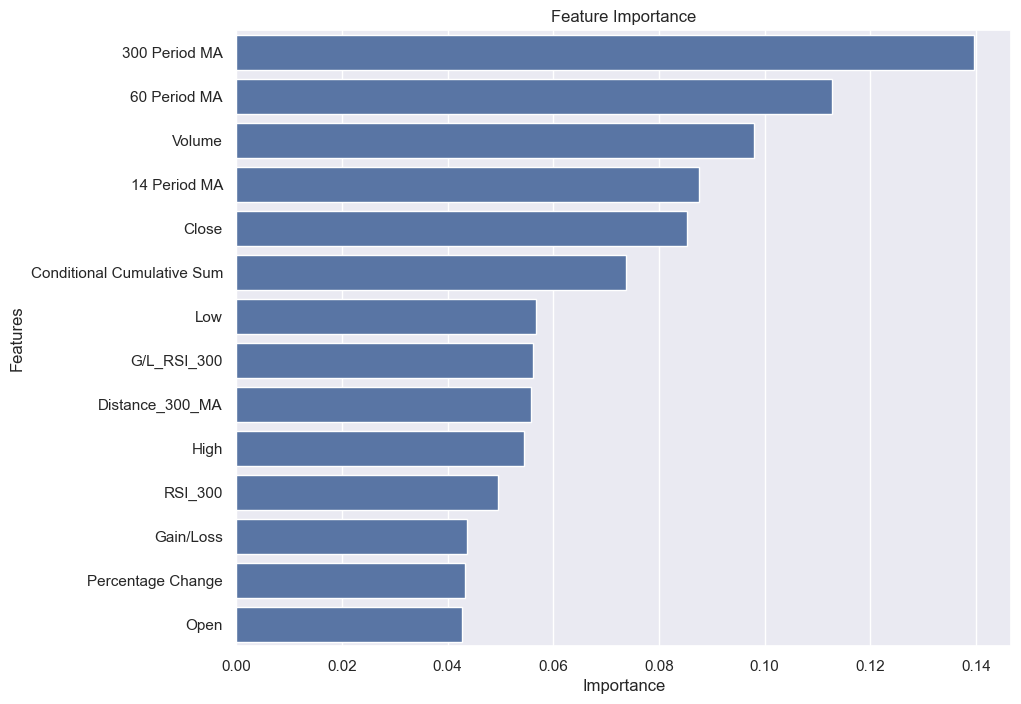

In [15]:
# Assuming 'rf' is your trained RandomForest model
feature_importances = rf_classifier.feature_importances_

# Assuming you have a DataFrame 'X_train' from which you can get feature names
features = X_train.columns

# Create a DataFrame to hold feature names and their corresponding importance
importances_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
print(importances_df)

# Plotting feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importances_df)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

In [16]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 2, 3, 4, 5, 6, 7])
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[63  5  0  0  1  1  1]
 [ 8 24  9  0  0  1  0]
 [ 3  7 15  4  2  0  1]
 [ 1  0  4  0  2  2  1]
 [ 0  1  0  2  5  4  1]
 [ 0  1  1  2  1  0  1]
 [ 0  0  0  0  1  2  2]]


In [17]:
class_report = classification_report(y_test, y_pred, labels=[0, 2, 3, 4, 5, 6, 7])
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.68      0.68        92
           2       0.51      0.39      0.44        61
           3       0.47      0.42      0.44        36
           4       0.00      0.00      0.00        10
           5       0.38      0.36      0.37        14
           6       0.00      0.00      0.00         7
           7       0.29      0.25      0.27         8

   micro avg       0.51      0.48      0.49       228
   macro avg       0.33      0.30      0.31       228
weighted avg       0.51      0.48      0.49       228



In [18]:
# Calculate per-class accuracy from the confusion matrix
class_accuracy = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
labels = [0, 2, 3, 4, 5, 6, 7]
for label, accuracy in zip(labels, class_accuracy):
    print(f"Accuracy for class {label}: {accuracy:.2f}")

Accuracy for class 0: 0.89
Accuracy for class 2: 0.57
Accuracy for class 3: 0.47
Accuracy for class 4: 0.00
Accuracy for class 5: 0.38
Accuracy for class 6: 0.00
Accuracy for class 7: 0.40


# Win Loss Only

In [19]:
y_train_binary = (y_train > 0).astype(int)
y_test_binary = (y_test > 0).astype(int)

In [20]:
# Option 1: Retrain the model
rf_classifier.fit(X_train, y_train_binary)
y_pred_binary = rf_classifier.predict(X_test)

# Option 2: Adjust existing predictions without retraining
y_pred_binary = (y_pred_binary > 0).astype(int)

In [21]:
joblib.dump(rf_classifier,"RFClassifier.joblib")

['RFClassifier.joblib']

In [22]:
accuracy2 = accuracy_score(y_test_binary, y_pred_binary)
print(f"Accuracy: {accuracy2:.2f}")

Accuracy: 0.83


In [23]:
# Create a DataFrame with actual and predicted values
results_df2 = pd.DataFrame({
    'Actual Values': y_test_binary,
    'Predicted Values': y_pred_binary
})

# Optionally, reset index to make it cleaner
results_df2.reset_index(drop=True, inplace=True)

In [24]:
results_df2.tail(20)

,Actual Values,Predicted Values
292,1,1
293,0,0
294,1,1
295,1,1
296,1,1
297,1,1
298,1,0
299,1,1
300,1,1
301,1,1


                       Feature  Importance
8                300 Period MA    0.147684
9                 60 Period MA    0.139167
10                14 Period MA    0.127208
3                        Close    0.083940
11             Distance_300_MA    0.079608
4                       Volume    0.061670
12                     RSI_300    0.061336
1                         High    0.060444
7   Conditional Cumulative Sum    0.050626
0                         Open    0.048729
2                          Low    0.047722
13                 G/L_RSI_300    0.033279
5                    Gain/Loss    0.029707
6            Percentage Change    0.028880


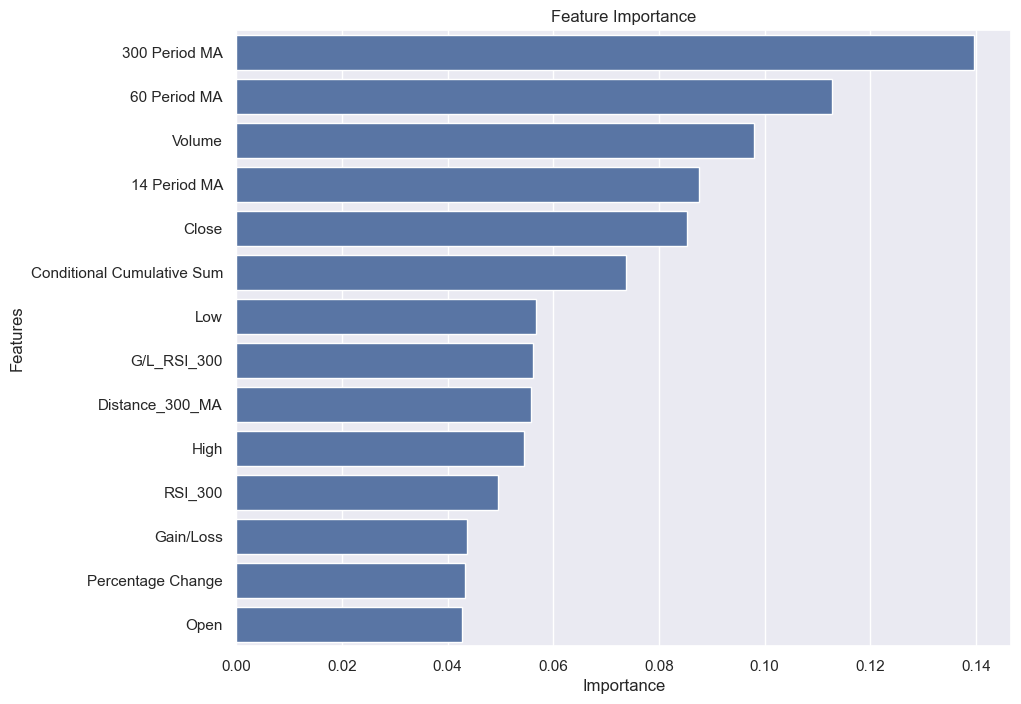

In [25]:
#Assuming 'rf' is your trained RandomForest model
feature_importances2 = rf_classifier.feature_importances_

# Assuming you have a DataFrame 'X_train' from which you can get feature names
features2 = X_train.columns

# Create a DataFrame to hold feature names and their corresponding importance
importances_df2 = pd.DataFrame({'Feature': features2, 'Importance': feature_importances2})

# Sort the DataFrame by importance in descending order
importances_df2 = importances_df2.sort_values(by='Importance', ascending=False)

# Display the feature importances
print(importances_df2)

# Plotting feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importances_df)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

Binary Accuracy: 0.83
              precision    recall  f1-score   support

     Class 0       0.77      0.59      0.67        92
    Class 1+       0.84      0.93      0.88       220

    accuracy                           0.83       312
   macro avg       0.81      0.76      0.77       312
weighted avg       0.82      0.83      0.82       312

Binary Confusion Matrix:
[[ 54  38]
 [ 16 204]]


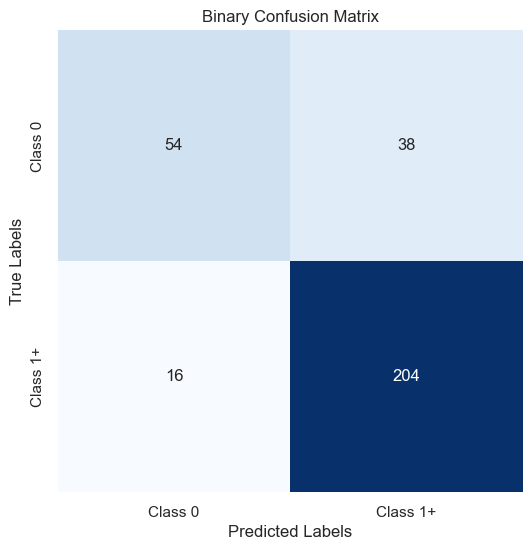

In [26]:
# Calculate binary accuracy
binary_accuracy = accuracy_score(y_test_binary, y_pred_binary)
print(f"Binary Accuracy: {binary_accuracy:.2f}")

# Print classification report for binary classification
print(classification_report(y_test_binary, y_pred_binary, target_names=['Class 0', 'Class 1+']))

# Generate and print the binary confusion matrix
binary_conf_matrix = confusion_matrix(y_test_binary, y_pred_binary)
print("Binary Confusion Matrix:")
print(binary_conf_matrix)

# Plotting the binary confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(binary_conf_matrix, annot=True, fmt="d", cmap='Blues', cbar=False)
plt.title('Binary Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks([0.5, 1.5], ['Class 0', 'Class 1+'])
plt.yticks([0.5, 1.5], ['Class 0', 'Class 1+'], va='center')
plt.show()

Precision: Interpretation: High precision relates to the low false positive rate. It indicates the accuracy of positive predictions and is particularly important in situations where the cost of a false positive is high.

Recall gives us a measure of how many actual positives our model can capture through labeling it as Positive (TP). It is particularly crucial in situations where missing a positive instance is significantly worse than getting a false positive.

The F1 score is often more useful than accuracy, especially if you have an uneven class distribution. It balances the trade-offs between precision and recall.

Binary Accuracy: 0.64
              precision    recall  f1-score   support

     Class 0       0.45      0.64      0.53      2615
    Class 1+       0.80      0.64      0.71      5734

    accuracy                           0.64      8349
   macro avg       0.62      0.64      0.62      8349
weighted avg       0.69      0.64      0.65      8349

In [27]:
# Create a DataFrame for the test features
df_test = X_test.copy()

# Add actual and predicted labels to the DataFrame
df_test['Actual Class'] = y_test_binary
df_test['Predicted Class'] = y_pred_binary

In [28]:
df_correct_ones = df_test[(df_test['Actual Class'] == 1) & (df_test['Predicted Class'] == 1)]
joinned_df = df.join(df_correct_ones[['Actual Class', 'Predicted Class']])
df_correct_ones.shape

(204, 16)

In [29]:
df_incorrect_ones = df_test[(df_test['Actual Class'] == 0) & (df_test['Predicted Class'] == 1)]
joinned_df_inc = df.join(df_incorrect_ones[['Actual Class', 'Predicted Class']])
df_incorrect_ones.shape

(38, 16)

In [30]:
joinned_df_clean = joinned_df.dropna()
joinned_df_inc_clean = joinned_df_inc.dropna()

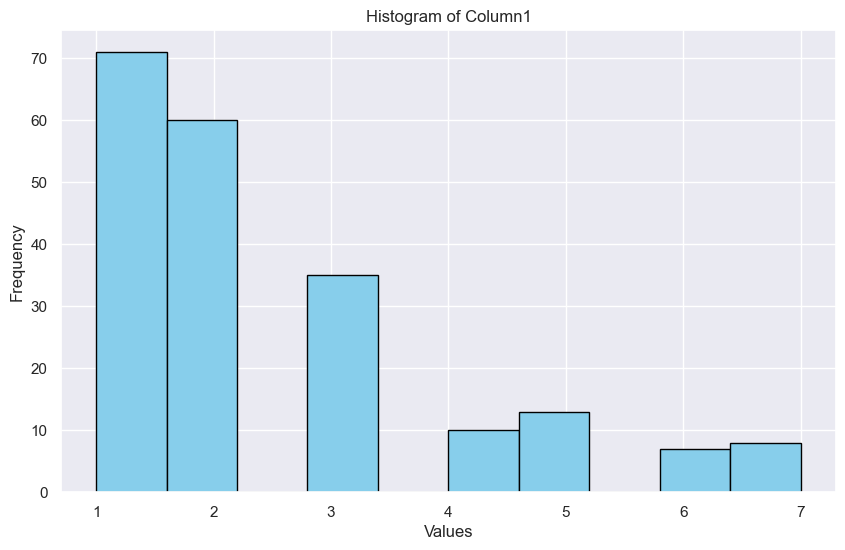

In [31]:
# Create a histogram of the data
plt.figure(figsize=(10, 6))  # Set the figure size (optional)
plt.hist(joinned_df_clean['Processed Difference'], bins=10, color='skyblue', edgecolor='black')  # You can adjust the number of bins
plt.title('Histogram of Column1')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)  # Optional: adds a grid
plt.show()

In [32]:
# Count the occurrences of each value in Column1
value_counts = joinned_df_clean['Processed Difference'].value_counts()
print(value_counts)

Processed Difference
1.0    71
2.0    60
3.0    35
5.0    13
4.0    10
7.0     8
6.0     7
Name: count, dtype: int64


In [33]:
# Calculate total number of entries in the column
total_entries = len(joinned_df_clean['Processed Difference'])

# Calculate the probability of each value
probabilities = value_counts / total_entries

probabilities_100=probabilities*100

print(probabilities_100.map("{:.2f}%".format))

# Sort probabilities in descending order
sorted_probabilities = probabilities.sort_index(ascending=False)

# Calculate the cumulative sum of sorted probabilities
cumulative_probabilities = sorted_probabilities.cumsum()

# Convert cumulative probabilities to percentage
cumulative_probabilities_percentage = cumulative_probabilities * 100

# Display the cumulative probabilities in percentage format
print(cumulative_probabilities_percentage.map("{:.2f}%".format))

Processed Difference
1.0    34.80%
2.0    29.41%
3.0    17.16%
5.0     6.37%
4.0     4.90%
7.0     3.92%
6.0     3.43%
Name: count, dtype: object
Processed Difference
7.0      3.92%
6.0      7.35%
5.0     13.73%
4.0     18.63%
3.0     35.78%
2.0     65.20%
1.0    100.00%
Name: count, dtype: object


In [34]:
df_future_val = pd.read_json('/Users/goldenhello/Desktop/Quant/Matic_Strategy/data_futures.json')

In [35]:
joinned_df_2 = joinned_df_clean.join(df_future_val[[ 'Close_future_1', 'Close_future_2', 'Close_future_3', 'Close_future_4',
       'Close_future_5', 'Close_future_6', 'Close_future_7', 'Close_future_8',
       'Close_future_9', 'Close_future_10']])

In [36]:

# List of columns to consider for the minimum value
columns_to_consider = ['Close_future_1', 'Close_future_2', 'Close_future_3', 'Close_future_4',
       'Close_future_5', 'Close_future_6', 'Close_future_7', 'Close_future_8',
       'Close_future_9', 'Close_future_10']

# Create a new column 'Min_Value' with the minimum of the specified columns
joinned_df_2['Lowest Min'] = joinned_df_2[columns_to_consider].min(axis=1)

In [37]:
joinned_df_2['Stop Loss_Min'] = joinned_df_2['Close'] - joinned_df_2['Lowest Min']
joinned_df_2.loc[joinned_df_2['Stop Loss_Min'] < 0, 'Stop Loss_Min'] = 0
stop_loss = joinned_df_2['Stop Loss_Min'].mean()

In [38]:
correct = df_correct_ones.shape[0]
incorrect = df_incorrect_ones.shape[0]

In [39]:
joinned_df_2.columns

Index(['Open time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Gain/Loss',
       'Percentage Change', 'Conditional Cumulative Sum', '300 Period MA',
       '60 Period MA', '14 Period MA', 'Distance_300_MA', 'RSI_300',
       'Processed Difference', 'G/L_RSI_300', 'Actual Class',
       'Predicted Class', 'Close_future_1', 'Close_future_2', 'Close_future_3',
       'Close_future_4', 'Close_future_5', 'Close_future_6', 'Close_future_7',
       'Close_future_8', 'Close_future_9', 'Close_future_10', 'Lowest Min',
       'Stop Loss_Min'],
      dtype='object')

In [40]:
analysis_1 = joinned_df_2[['Open', 'Close', 'Predicted Class','Actual Class','Processed Difference','Stop Loss_Min','RSI_300']]

In [41]:
joinned_df_2.columns

Index(['Open time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Gain/Loss',
       'Percentage Change', 'Conditional Cumulative Sum', '300 Period MA',
       '60 Period MA', '14 Period MA', 'Distance_300_MA', 'RSI_300',
       'Processed Difference', 'G/L_RSI_300', 'Actual Class',
       'Predicted Class', 'Close_future_1', 'Close_future_2', 'Close_future_3',
       'Close_future_4', 'Close_future_5', 'Close_future_6', 'Close_future_7',
       'Close_future_8', 'Close_future_9', 'Close_future_10', 'Lowest Min',
       'Stop Loss_Min'],
      dtype='object')

In [42]:
analysis_1.tail(50)

,Open,Close,Predicted Class,Actual Class,Processed Difference,Stop Loss_Min,RSI_300
1124,175.835007,175.860001,1.0,1.0,3.0,7.509903,48.701993
1132,176.149994,176.220795,1.0,1.0,2.0,7.025101,49.190534
1140,176.449203,176.455002,1.0,1.0,1.0,7.324997,49.656543
1155,176.320007,176.421997,1.0,1.0,2.0,7.401993,49.473412
1156,176.423401,176.429993,1.0,1.0,2.0,7.409988,49.636734
1170,175.206802,175.535004,1.0,1.0,4.0,7.785004,47.899894
1173,175.339996,176.500000,1.0,1.0,7.0,8.750000,48.142946
1175,176.910004,177.646393,1.0,1.0,2.0,9.646393,50.400003
1193,175.163895,174.955002,1.0,1.0,7.0,7.095001,48.171512
1210,175.809998,175.410095,1.0,1.0,2.0,6.795090,49.083402


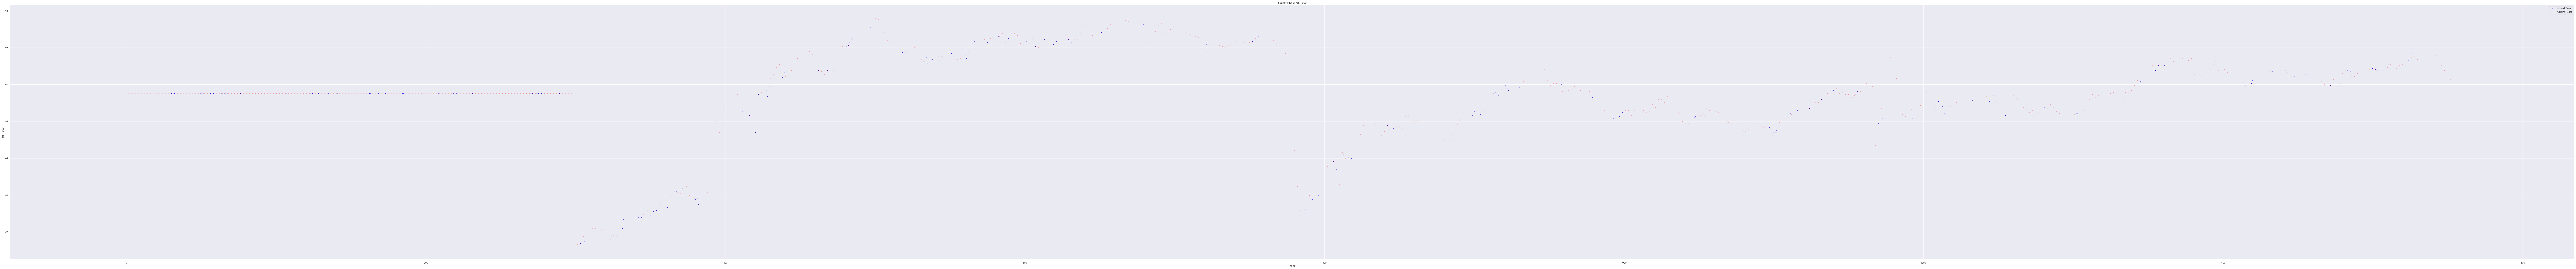

In [43]:
import matplotlib.pyplot as plt

# Assuming joinned_df_clean and df are already defined and cleaned DataFrames

# Plotting
plt.figure(figsize=(200, 20))
# Scatter plot for joinned_df_clean with smaller dots
plt.scatter(joinned_df_clean.index, joinned_df_clean['RSI_300'], color='blue', label='Joined Data', s=5)  # smaller dot size
# Scatter plot for df with smaller dots
plt.scatter(df.index, df['RSI_300'], color='red', label='Original Data', s=0.1)  # smaller dot size

# Adding titles and labels
plt.title('Scatter Plot of RSI_300')
plt.xlabel('Index')
plt.ylabel('RSI_300')

# Adding a legend to differentiate the sets
plt.legend()

# Show the plot
plt.show()
